# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides in the `color_sobel_edges()` function below.  Use sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gyz.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

As usual, the input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.



In [5]:
import skimage.util as util
import numpy as np


def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j,:] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I):
    '''
    Vector gradient using partial derivatives estimated using Sobel filters.
    :param I: Input image.
    :return: a tuple consisting of the magnitude image and the gradient direction image.
    '''
    
    
    if I.dtype == 'uint8':
        I = util.img_as_float(I)
    elif I.dtype != 'float':
        raise TypeError("Input image must be dtype 'float' or 'uint8'.")

    # Filter each channel to get horizontal partial derivatives.
    u = [ filt.sobel_h(I[:,:,i]) for i in range(3)]

    # Stack the results back into a 3D image.
    u = np.dstack(u)

    # Do same for vertical partial derivative.
    v = [ filt.sobel_v(I[:,:,i]) for i in range(3)]
    v = np.dstack(v)

    # Obtain the dot products we need for the formula.
    gxx = color_dot_product(u, u)
    gyy = color_dot_product(v, v)
    gxy = color_dot_product(u, v)

    # Compute gradient direction because we need it to compute the magnitude.
    theta = 0.5 * np.arctan2(2*gxy, gxx-gyy)

    # Compute gradient magnitude from the formula.
    mag = np.sqrt(0.5 * ((gxx + gyy) + (gxx-gyy) * np.cos(2 * theta) + (2*gxy) * np.sin(2*theta)))

    return mag, theta

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for integer values of sigma between the provided minimum and maximum values of sigma. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
* For each blurred image, compute the gradient magnitude using color_sobel_edges(), then compute compute the kurtosis sharpness measure.  This is the log(kurtosis+3) where kurtosis is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See 'scipy.stats.kurtosis()`.
* Return a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



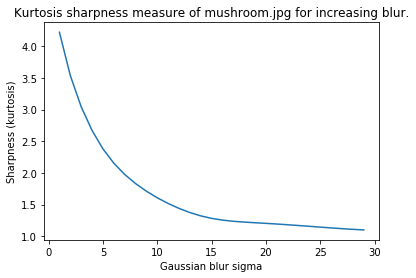

In [11]:
import skimage.io as io
import scipy.stats as stats
import skimage.filters as filt
import matplotlib.pyplot as plt


% matplotlib inline

def test_blur_measure(I, min_sigma, max_sigma):

    sharp = []
    sigma_range = np.arange(min_sigma, max_sigma)
    for s in sigma_range:
        F = filt.gaussian(I, sigma=s, multichannel=True)
        mag, theta = color_sobel_edges(F)
        sharp.append(np.log(stats.kurtosis(mag.reshape(mag.size, 1))+3))

    return sharp, sigma_range


I = io.imread('mushroom.jpg')
(sharp, sigma_range) = test_blur_measure(I, 1, 30)

plt.figure()
plt.plot(sigma_range, sharp)
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of mushroom.jpg for increasing blur.')
plt.savefig('q1-step2-sampleoutput.pdf')

# Step 3:  Create a local blur map

Write a function which:

* cakes as input an input image and a window size (in pixels).
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  Add a colormap using `plt.colormap()`.  Sample output is provided in the assignment description document.



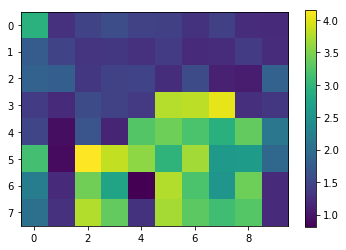

In [7]:
def sharpness_map(I, window_size):

    output_map = np.zeros( (I.shape[0]//window_size, I.shape[1]//window_size) )

    for r in range(output_map.shape[0]):
        for c in range(output_map.shape[1]):
            patch = I[r*window_size:r*window_size+window_size, c*window_size:c*window_size+window_size]
            mag, theta = color_sobel_edges(patch)
            output_map[r, c] = np.log(stats.kurtosis(mag.reshape(mag.size, 1))+3)

    return output_map
    
    
plt.figure()
plt.imshow(sharpness_map(I, 100))
plt.colorbar()
#plt.savefig('q1-step3-sampleoutput.pdf')

# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


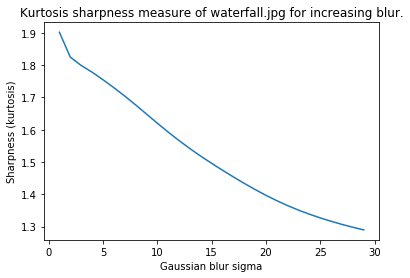

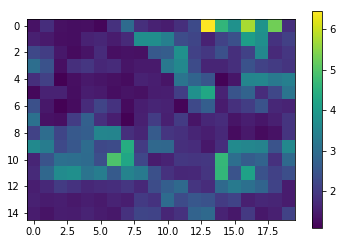

In [10]:
J = io.imread('waterfall.jpg')
(sharp, sigma_range) = test_blur_measure(J, 1, 30)

plt.figure()
plt.plot(sigma_range, sharp)
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of waterfall.jpg for increasing blur.')
#plt.savefig('q1-step4-sampleoutput-1.pdf')

plt.figure()
plt.imshow(sharpness_map(J, 100))
plt.colorbar()
#plt.savefig('q1-step4-sampleoutput-2.pdf')


# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Do you think that the log(kurtosis+3) measurement of sharpness (hereafter called the "sharpness measure") is a good measure for characterizing global image blur (the general amount that the entire image is blurred)?  Explain and justify your answer.

	_Your answer:_  I'd expect the answer here to be generally "yes".   The as the images are blurred, the sharpness measure of the image decreases.  A disadvantage would be that the decrease does not seem to be linear.

2. Is the sharpness measure effective at characterizing variations in local blur?  Does it respond to different regions of images appropriately?  Explain and justify your answers.

	_Your answer:_  I'd expect the answer here to be generally "yes", but with some caveats.  It does seem to do a good job distinguishing between out-of-focus regions and in-focus regions in the mushroom image.  However, there are disadvantages.  Firstly, a lot of samples are needed to accurately compute kurtosis, meaning that the window size can't be too small. This limits the locality of the measure.  Another peculiar thing is that it seems to observe a lot of variation in sharpness in the waterfall image despite the fact that the image seems to be all in focus.  It could be that the window size needs to be increased for this image (it is larger than the mushroom image).  Even if this works, it's another disadvantage since the window size now has to depend on the image scale.

3. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	_Your answer:_  A very sharp image would have a narrow peak of high gradients in the gradient magnitude histogram with at least one long tail.  Kurtosis measures "peakedness".  So a very high peaked histogram would exhibit a high kurtosis.

4. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	_Your answer:_  The high gradient magnitudes would be decreased by different amounts, making the narrow peak in the histogram shorter and wider, in other words, less "peaked".  Thus the kurtosis is lower, and the sharpness measure decreases.